# KNN

In [28]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier

from preprocessing import *

plt.rcParams["figure.dpi"] = 60

# Carga del dataset
Leemos el dataset y lo separamos en datos de training y de evaluación.

In [24]:
df = pd.read_csv("df_train.csv")
X = df.drop(columns=['llovieron_hamburguesas_al_dia_siguiente'])
y = df['llovieron_hamburguesas_al_dia_siguiente']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y.astype(str))

# Selección de modelos

Para encontrar el mejor modelo, probaremos utilizando 3 preprocesamientos distintos. 
Dado que KNN depende de la posición de los puntos en el espacio, es necesario escalar los datos.
Los preprocesamientos que usamos eliminan las variables categóricas y aplican uno de los siguientes scalers: 

- **StandardScaler**: transforma los datos para que tengan media 0 y varianza 1.
- **MinMaxScaler**: transforma los datos para que tengan valores entre 0 y 1.
- **Normalizer**: normaliza individualmente cada fila del dataset, con norma 1.

Por cada uno de ellos, buscaremos la mejor combinación de hiperparámetros mediante Randomized Search, con el objetivo de maximizar la métrica AUC ROC. Dado que la búsqueda de hiperparámetros toma un tiempo mayor que otros modelos, solamente haremos 10 iteraciones con 3 folds de cross-validation en lugar de 5.

Los hiperparámetros que buscaremos son:
- **n_neighbors:** Es la cantidad (k) de vecinos más cercanos que se consideran al clasificar una instancia nueva. Para valores de k muy pequeños (cercanos a 1), el modelo tiende al overfitting, mientras que para valores muy grandes (cercanos a la cantidad de instancias) tiende al underfitting. Si se utiliza un k muy grande, el tiempo que tarda en realizar la predicción aumenta mucho, por lo tanto probaremos con valores entre 10 y 150.
- **weights:** determina cómo se pondera la cantidad de vecinos. Puede ser *uniform* (sin ponderación) o *distance* (la importancia de un vecino es inversamente proporcional a la distancia).


Primero probamos con StandardScaler:

In [3]:
X_train1 = preprocessing_knn_standard(X_train)
params = {
    'n_neighbors': np.arange(10, 150, 10),
    'weights': ['uniform', 'distance'],
}

knn1 = KNeighborsClassifier(algorithm='kd_tree')

gscv1 = RandomizedSearchCV(
    knn1, params, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=3, return_train_score=True
).fit(X_train1, y_train)

print(f"Best score: {gscv1.best_score_}")
print(f"Best params {gscv1.best_params_}")

Best score: 0.8693663877178902
Best params {'weights': 'distance', 'n_neighbors': 100}


Luego probamos con MinMaxScaler:

In [4]:
X_train2 = preprocessing_knn_min_max(X_train)
params = {
    'n_neighbors': np.arange(10, 150, 10),
    'weights': ['uniform', 'distance'],
}

knn2 = KNeighborsClassifier(algorithm='kd_tree')

gscv2 = RandomizedSearchCV(
    knn2, params, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=3, return_train_score=True
).fit(X_train2, y_train)

print(f"Best score: {gscv2.best_score_}")
print(f"Best params {gscv2.best_params_}")

Best score: 0.8675784662465255
Best params {'weights': 'distance', 'n_neighbors': 120}


Por último, utilizamos Normalizer:

In [5]:
X_train3 = preprocessing_knn_normalizer(X_train)
params = {
    'n_neighbors': np.arange(10, 150, 10),
    'weights': ['uniform', 'distance'],
}

knn3 = KNeighborsClassifier(algorithm='kd_tree')

gscv3 = RandomizedSearchCV(
    knn3, params, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=3, return_train_score=True
).fit(X_train3, y_train)

print(f"Best score: {gscv3.best_score_}")
print(f"Best params {gscv3.best_params_}")

Best score: 0.8570203863271639
Best params {'weights': 'distance', 'n_neighbors': 140}


# Evaluación del modelo final

El mejor modelo encontrado corresponde al preprocesamiento preprocessing_knn_standard, con weights': 'distance', 'n_neighbors': 100.
Entrenamos el modelo y evaluamos utilizando el set de evaluacion.

In [25]:
X_eval = preprocessing_knn_standard(X_eval)

knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=100, weights='distance')
knn.fit(X_train1, y_train)

y_pred = knn.predict(X_eval)
y_pred_proba = knn.predict_proba(X_eval)[:,1]

In [26]:
print(f"Auc Roc: {roc_auc_score(y_eval, y_pred_proba)}")
print(f"Accuracy: {accuracy_score(y_eval, y_pred)}")
print(f"Precision: {precision_score(y_eval, y_pred)}")
print(f"Recall: {recall_score(y_eval, y_pred)}")
print(f"F1 Score: {f1_score(y_eval, y_pred)}")

Auc Roc: 0.8765817477528707
Accuracy: 0.8474068152293395
Precision: 0.7593297791317594
Recall: 0.45153985507246375
F1 Score: 0.566316387389946


De las métricas podemos destacar que se obtuvo un accuracy de 0.85, mayor que el accuracy del baseline obtenido en el TP1 (0.83). Dado que el accuracy no es una buena métrica para evaluar un modelo cuando se usa un dataset desbalanceado como este, la métrica que usamos para comparar los modelos es AUC, la cual tiene un valor de 0.88.

También vemos que el recall obtenido (0.45) es mucho menor que el precision (0.76). Esto significa que, de todas las instancias que son realmente positivas (es decir, llueven hamburguesas al día siguiente), el modelo solo detecta correctamente el 45% de ellas. Por otro lado, de las que el modelo predice como positivas, el 76% eran realmente positivas.

Lo que se destaca de esto es que el recall es el más bajo obtenido en este TP, y a su vez el precision es el más alto. Esto se debe a que KNN predice muy pocos positivos, pero tiende a hacerlo correctamente. En el caso del modelo de Naive Bayes que utilizamos en este TP, por ejemplo, sucede lo contrario: el modelo predice una cantidad muy grande de positivos, lo cual hace que su recall sea alto pero su precision sea bajo.

Por último, el F1 Score permite tener una única métrica para evaluar el modelo, teniendo en cuenta el recall y el precision:

    F1 = 2 x (precision x recall) / (precision + recall) = 0.57

Para analizar con más detalle estas métricas, graficaremos la matriz de confusión y la curva ROC.

## Matriz de confusión

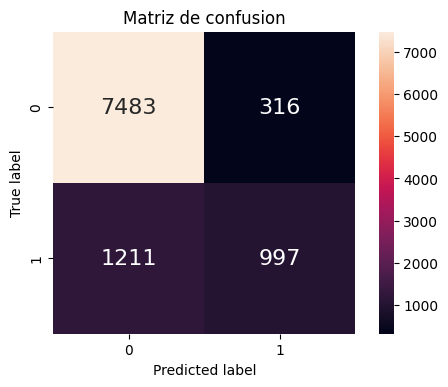

In [29]:
names = sorted(set(y_eval))
cm = confusion_matrix(y_eval, y_pred)
df_cm = pd.DataFrame(cm, names, names)

plt.figure(dpi=100)
plt.title("Matriz de confusion")
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

En la matriz de confusión podemos observar exactamente cuántas instancias fueron predichas como True Positive, True Negative, False Positive y False Negative. Nuevamente destacamos la baja cantidad de instancias predecidas como positivas. A partir de estos datos se pueden calcular las métricas, verificando los resultados obtenidos anteriormente:
- Recall = TP/(TP+FN) = 997/(997+1211) = 0.45
- Precision = TP/(TP+FP) = 997/(997+316) = 0.76
- Accuracy = (TP+TN)/total = 8480/10007 = 0.85

## Curva ROC

La curva ROC se obtiene al graficar el True Positive Rate (Recall) vs el False Positive Rate, variando el umbral de detección entre 0 y 100%. Si las predicciones hechas fueran completamente aleatorias, la curva sería una recta, con un área bajo la curva de 0.5. El área bajo la curva es la métrica que se obtiene de la curva, y por eso se busca obtener valores mayores que 0.5. En este caso se obtuvo un AUC = 0.88, el cual es un buen valor comparado con otros modelos utilizados en este TP.

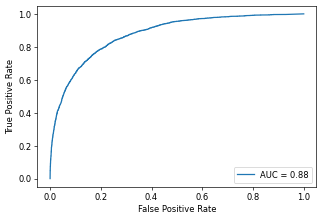

In [30]:
fpr, tpr, thresholds = roc_curve(y_eval, y_pred_proba)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

# Predicciones finales
Finalmente, utilizaremos el modelo para predecir la lluvia de hamburguesas a partir de datos que no fueron usados en el entrenamiento. Guardaremos las predicciones en un archivo csv.

In [31]:
X_train1 = preprocessing_knn_standard(X_train)

knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=100, weights='distance')
knn.fit(X_train1, y_train)

df_pred = pd.read_csv("pred.csv")
df_pred_preprocess = basic_preprocessing(df_pred, prediction_dataset=True)
df_pred_preprocess = fill_numerical_missings(df_pred_preprocess, X_train)
df_pred_preprocess = df_pred_preprocess.drop(columns = ['id'])
df_pred_preprocess = preprocessing_knn_standard(df_pred_preprocess)

y_pred_final = knn.predict(df_pred_preprocess)
df_pred_final = pd.DataFrame({'id': df_pred['id'], 'llovieron_hamburguesas_al_dia_siguiente': y_pred_final})
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 1, 'llovieron_hamburguesas_al_dia_siguiente'] = 'si'
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 0, 'llovieron_hamburguesas_al_dia_siguiente'] = 'no'

In [32]:
df_pred_final.to_csv('predicciones/knn.csv', index=False)